In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from torch.nn import L1Loss
from torch import torch
import os
import cv2
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import glob
from PIL import Image as PImage

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
src_size = 256

In [5]:
path = Path('./data/dataset')
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
label_fs = os.listdir(path_lbl)
for i,f in enumerate(label_fs):
#     print(i,str(path_lbl / f))
    label = cv2.imread(str(path_lbl / f))
    cv2.imwrite(str(path_lbl / f), np.clip(label, 0, 1))

In [7]:
get_y_fn = lambda x: path_lbl/x.name

In [8]:
codes = ["nothing", "fire"]

In [9]:
size = src_size//2

bs = 2

In [10]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [11]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [13]:
def _loss_func(preds, targs):
    # Loss multipliers are printed at the end of train_run, to balance the number of annotated pixels
    preds_b = preds[:,1,:,:].unsqueeze(1)
    preds_c = preds[:,0,:,:].unsqueeze(1)
    mask_benign = targs == 0
    masked_preds_benign = preds_c[mask_benign].float() - preds_b[mask_benign].float()
    masked_targs_benign = targs[mask_benign].float()
    if len(masked_targs_benign) > 0:
        loss_benign = L1Loss()(masked_preds_benign, masked_targs_benign) * 1
    else:
        loss_benign = torch.full((), 0., device=torch.device("cuda"))

    mask_clinsig = targs > 0
    masked_preds_clinsig = preds_c[mask_clinsig].float() - preds_b[mask_clinsig].float()
    masked_targs_clinsig = targs[mask_clinsig].float()
    if len(masked_preds_clinsig) > 0:
        loss_clinsig = L1Loss()(masked_preds_clinsig, masked_targs_clinsig) * 5
    else:
        loss_clinsig = torch.full((), 0., device=torch.device("cuda"))
    return loss_benign + loss_clinsig

acc_benign_vals = [0.]

def _acc_dice(preds, targs):
    preds_b = preds[:,1,:,:].unsqueeze(1)
    preds_c = preds[:,0,:,:].unsqueeze(1)
    preds = preds_c - preds_b
    global acc_benign_vals
    mask = (targs == 1) | (preds > 0.5)
    masked_preds = preds[mask].float()
    masked_targs = targs[mask].float()
    if len(masked_targs) == 0:
        out = torch.full((), np.average(acc_benign_vals), device=torch.device("cuda"))
    else:
        iou = ((masked_preds - masked_targs).abs() <= 0.5).float().mean()
        out = 2 * iou / (1 + iou)
        acc_benign_vals.append(out)
        if len(acc_benign_vals) > 200:
            acc_benign_vals = acc_benign_vals[-100:]
    return out

In [15]:
print('Define model')
learn = unet_learner(data, models.resnet34, metrics=_acc_dice, loss_func=_loss_func, wd=0.1, bottle=True,
                     blur_final=False, norm_type=NormType.Weight, self_attention=True)
learn.model_dir = os.getcwd()+"/models/"
print('Loading model')
learn.load('test_fire_detec3')
print('Loading image')
pil_im = PImage.open('0000008_008.png') 
x = pil2tensor(pil_im ,np.float32)


Define model
Loading model
Loading image


In [16]:
print('Run inference')
infer=learn.predict(Image(x)) #run inference


Run inference


Show inference results


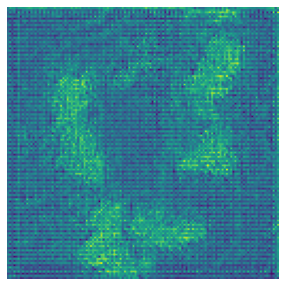

In [17]:
print('Show inference results')
segm = to_np(infer[0].data.permute(1, 2, 0) )
plt.figure(figsize=(10,5))
plt.imshow(infer[2][:1].permute(1, 2, 0)  )
plt.axis('off')
plt.savefig('segDetec.png')
plt.show()